### Can we classify each phase as relatively low or high anxiety for each subject? ###

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_wesad as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)


phases = dr.Phases.PHASE_ORDER


c:\Users\zhoux\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


y_train:
0    49
1    11
Name: label, dtype: int64
y_test:
0    6
1    4
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [9 1]
Calculating shap values
Model XGB, Predictions: [0 1], [8 2]
Calculating shap values
[[ 2.14457819  0.18647956  0.13215467  0.68125246 -0.49130792  1.02741731
   0.96341344 -0.64372255]]
[[ 2.14457819  0.18647956  0.13215467  0.68125246 -0.49130792  1.02741731
   0.96341344 -0.64372255]]


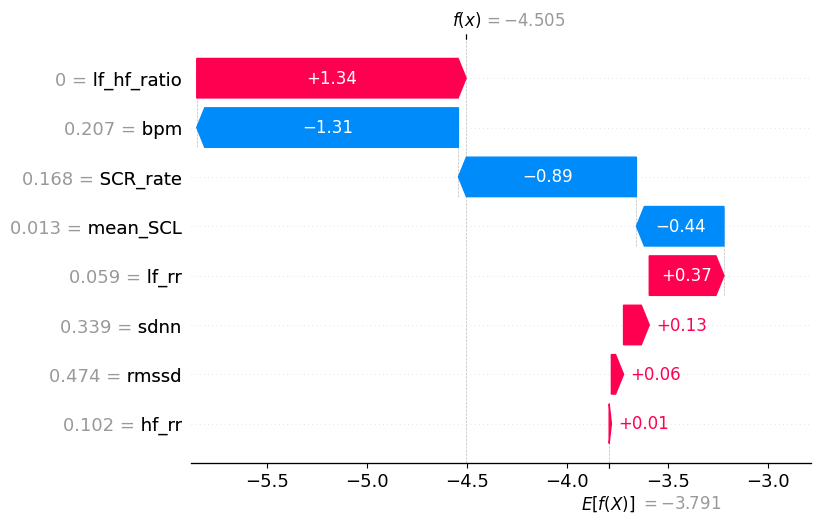

y_train:
0    48
1    12
Name: label, dtype: int64
y_test:
0    7
1    3
Name: label, dtype: int64
Model LogReg, Predictions: [0], [10]
Calculating shap values
Model RF, Predictions: [0 1], [9 1]
Calculating shap values
Model XGB, Predictions: [0 1], [9 1]
Calculating shap values
[[ 2.18658999  0.33406302  0.13997237  0.83457485 -0.3386463   1.02530335
   0.84843004 -0.59192529]]
[[ 2.18658999  0.33406302  0.13997237  0.83457485 -0.3386463   1.02530335
   0.84843004 -0.59192529]]


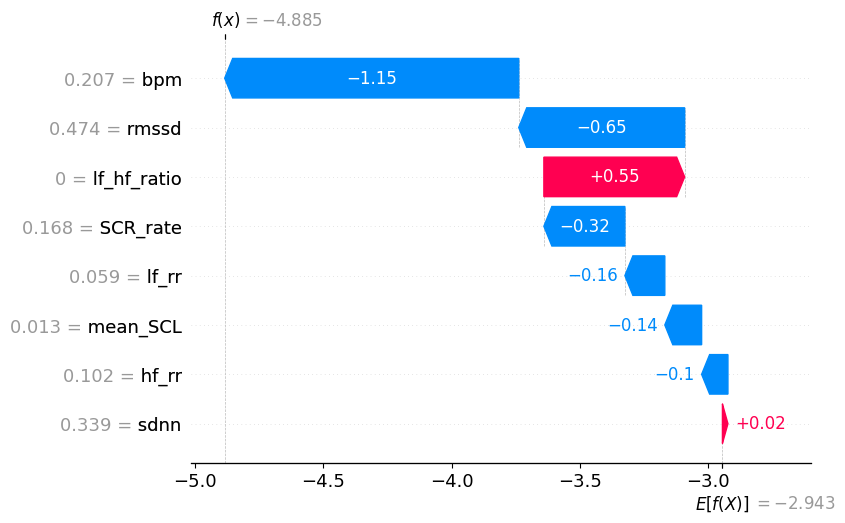

y_train:
0    47
1    13
Name: label, dtype: int64
y_test:
0    8
1    2
Name: label, dtype: int64
Model LogReg, Predictions: [0], [10]
Calculating shap values
Model RF, Predictions: [0 1], [8 2]
Calculating shap values
Model XGB, Predictions: [0 1], [9 1]
Calculating shap values
[[ 1.77242482  0.57033167  0.11560324  0.78103607  0.05897269  1.32392136
   0.70843055 -0.42664372]]
[[ 1.77242482  0.57033167  0.11560324  0.78103607  0.05897269  1.32392136
   0.70843055 -0.42664372]]


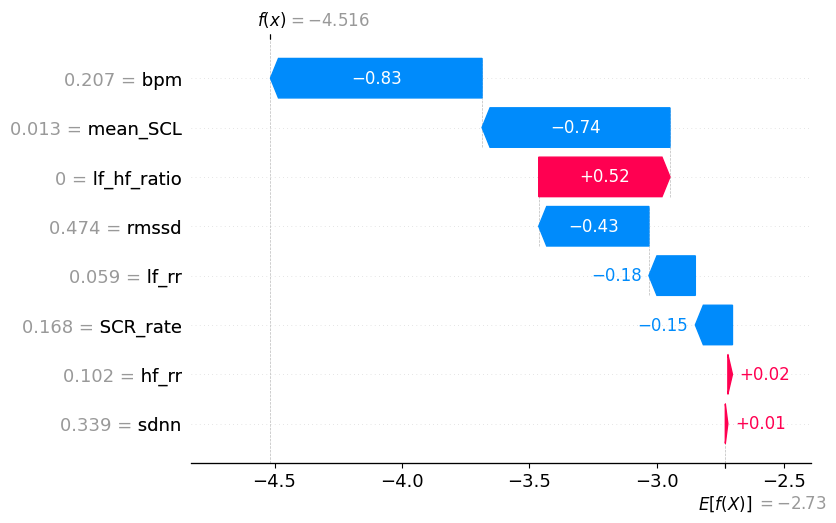

y_train:
0    47
1    13
Name: label, dtype: int64
y_test:
0    8
1    2
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [8 2]
Calculating shap values
Model XGB, Predictions: [0 1], [9 1]
Calculating shap values
[[ 1.74887786  0.33193751  0.40961279  0.89676163 -0.35443269  1.11730364
   0.68347936 -0.66271649]]
[[ 1.74887786  0.33193751  0.40961279  0.89676163 -0.35443269  1.11730364
   0.68347936 -0.66271649]]


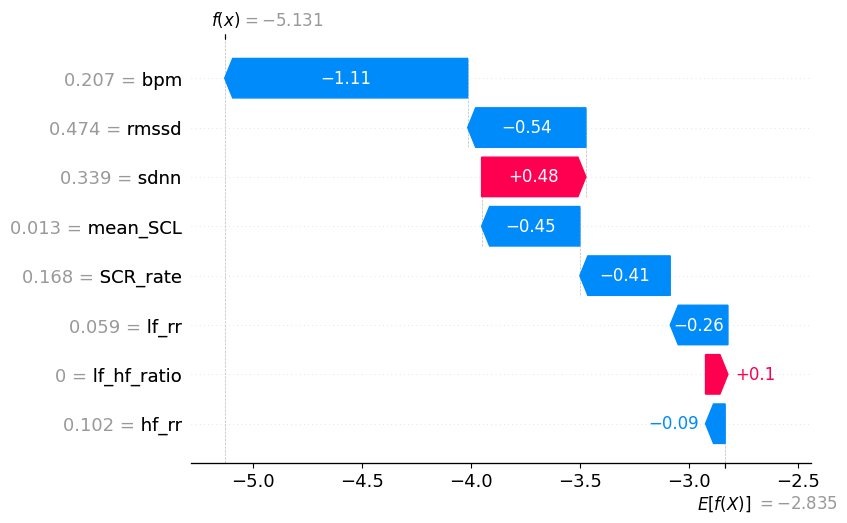

y_train:
0    47
1    13
Name: label, dtype: int64
y_test:
0    8
1    2
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [9 1]
Calculating shap values
Model XGB, Predictions: [0 1], [8 2]
Calculating shap values
[[ 1.75838259  0.12566816  0.36546977  0.81543021 -0.30929204  1.09965844
   0.74472733 -0.61751219]]
[[ 1.75838259  0.12566816  0.36546977  0.81543021 -0.30929204  1.09965844
   0.74472733 -0.61751219]]


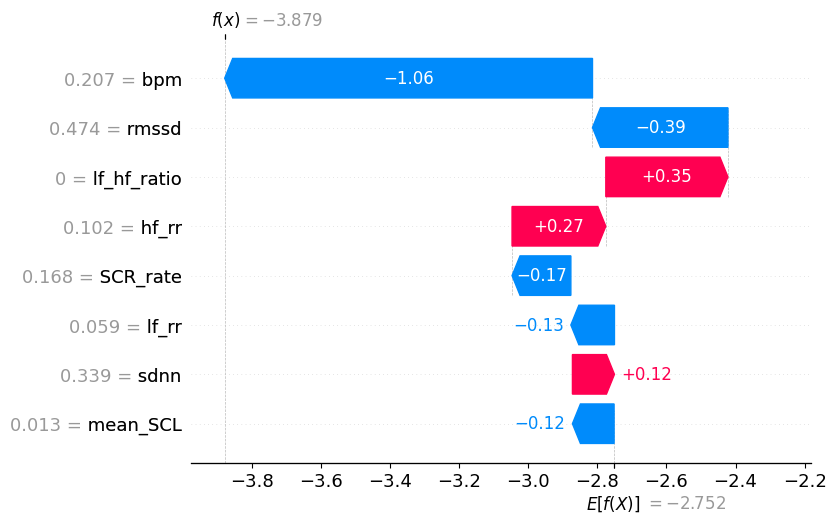

y_train:
0    48
1    12
Name: label, dtype: int64
y_test:
0    7
1    3
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [9 1]
Calculating shap values
Model XGB, Predictions: [0 1], [8 2]
Calculating shap values
[[ 1.90157887  0.04282271  0.0906071   0.65593004 -0.38022451  1.15189147
   0.86671482 -0.56812987]]
[[ 1.90157887  0.04282271  0.0906071   0.65593004 -0.38022451  1.15189147
   0.86671482 -0.56812987]]


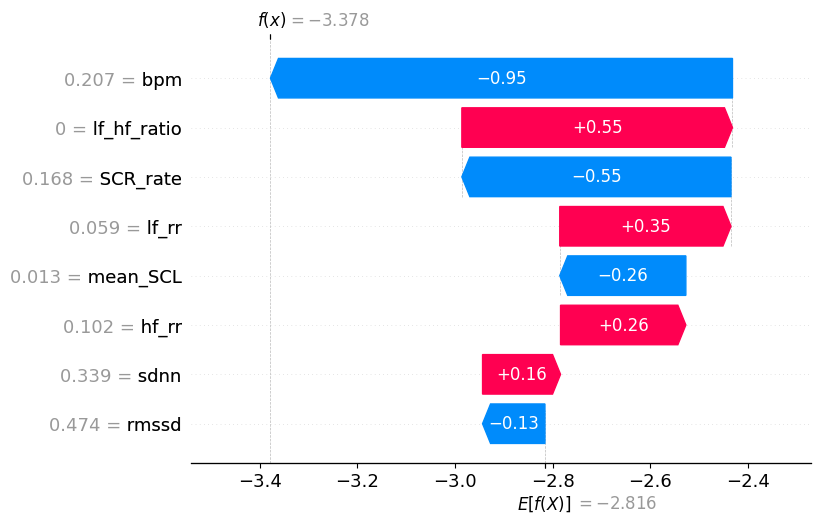

y_train:
0    48
1    12
Name: label, dtype: int64
y_test:
0    7
1    3
Name: label, dtype: int64
Model LogReg, Predictions: [0], [10]
Calculating shap values
Model RF, Predictions: [0], [10]
Calculating shap values
Model XGB, Predictions: [0 1], [9 1]
Calculating shap values
[[ 2.18658999  0.33406302  0.13997237  0.83457485 -0.3386463   1.02530335
   0.84843004 -0.59192529]]
[[ 2.18658999  0.33406302  0.13997237  0.83457485 -0.3386463   1.02530335
   0.84843004 -0.59192529]]


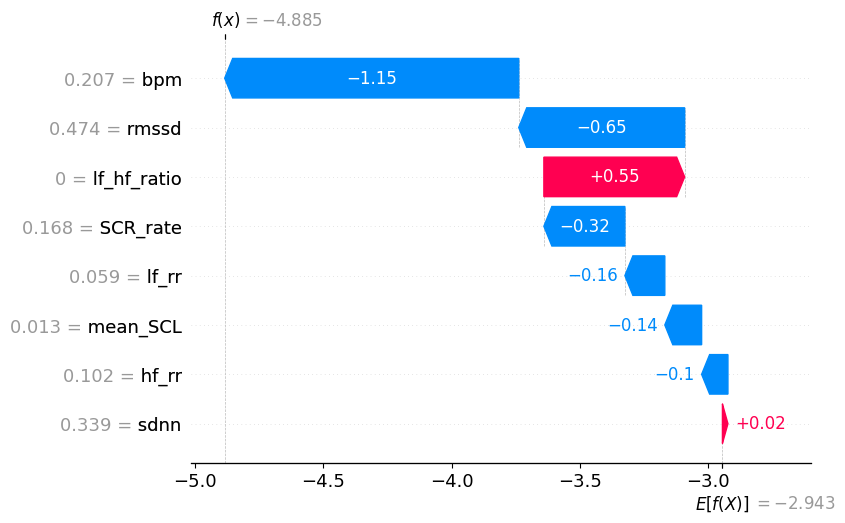

y_train:
0    47
1    13
Name: label, dtype: int64
y_test:
0    8
1    2
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [9 1]
Calculating shap values
Model XGB, Predictions: [0 1], [9 1]
Calculating shap values
[[ 2.02171565  0.35727113  0.08796     0.70941141 -0.23914492  1.01833133
   0.67973688 -0.54308611]]
[[ 2.02171565  0.35727113  0.08796     0.70941141 -0.23914492  1.01833133
   0.67973688 -0.54308611]]


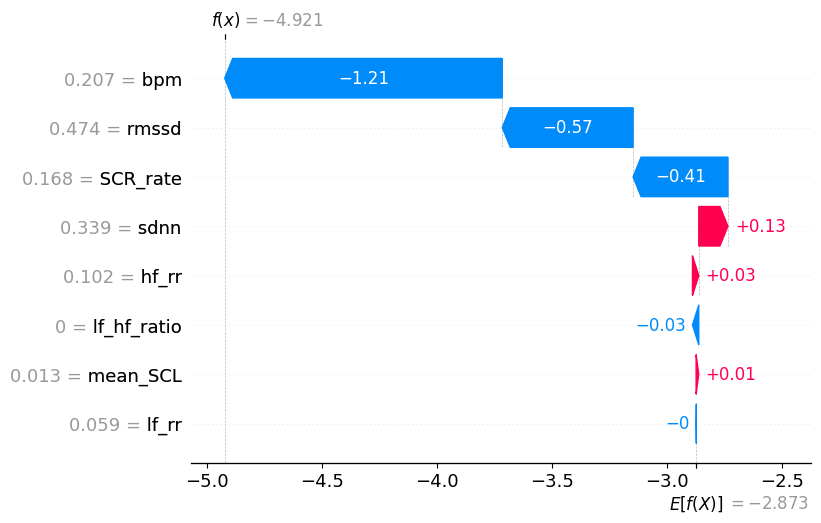

y_train:
0    47
1    13
Name: label, dtype: int64
y_test:
0    8
1    2
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [8 2]
Calculating shap values
Model XGB, Predictions: [0 1], [8 2]
Calculating shap values
[[ 1.95801242  0.39141256  0.02103402  0.61891834 -0.1631804   0.96176232
   0.88091668 -0.29740536]]
[[ 1.95801242  0.39141256  0.02103402  0.61891834 -0.1631804   0.96176232
   0.88091668 -0.29740536]]


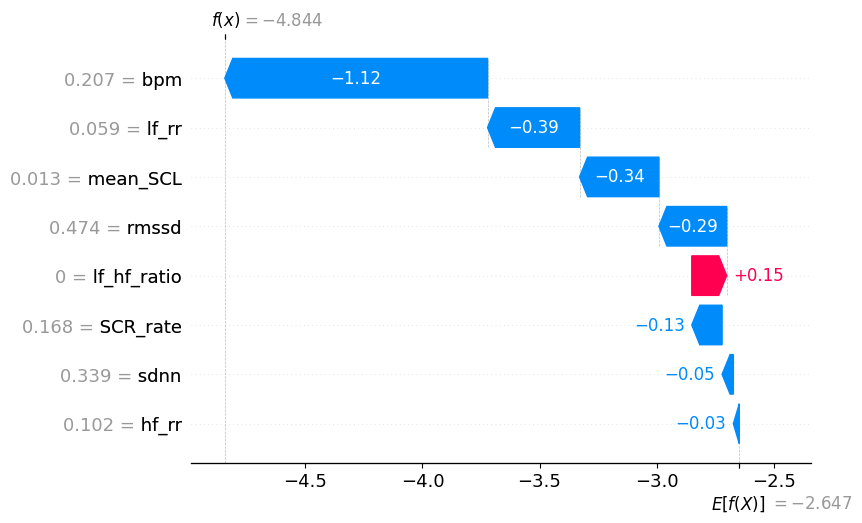

y_train:
0    46
1    14
Name: label, dtype: int64
y_test:
0    9
1    1
Name: label, dtype: int64
Model LogReg, Predictions: [0 1], [9 1]
Calculating shap values
Model RF, Predictions: [0 1], [8 2]
Calculating shap values
Model XGB, Predictions: [0 1], [6 4]
Calculating shap values
[[ 1.99744834  0.34242909  0.09668378  0.68771766 -0.18999548  1.13627241
   0.73725513 -0.48468595]]
[[ 1.99744834  0.34242909  0.09668378  0.68771766 -0.18999548  1.13627241
   0.73725513 -0.48468595]]


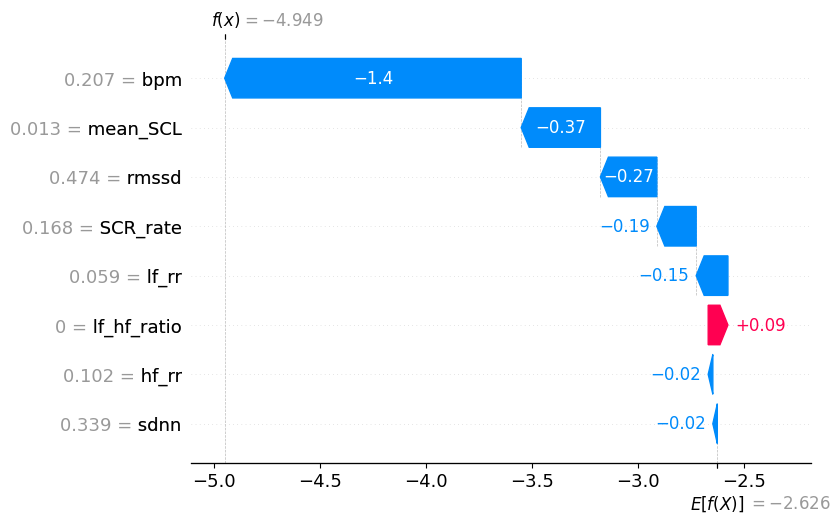

LogReg accuracy over 10 rounds: 0.8300000000000001
Model evaluation metrics for LogReg:
Precision: 0.7
Recall: 0.3583333333333333
F1-score: 0.45666666666666667
AUC score: 0.6791666666666666
RF accuracy over 10 rounds: 0.85
Model evaluation metrics for RF:
Precision: 0.8
Recall: 0.5416666666666666
F1-score: 0.59
AUC score: 0.7590277777777777
XGB accuracy over 10 rounds: 0.85
Model evaluation metrics for XGB:
Precision: 0.875
Recall: 0.5833333333333333
F1-score: 0.6366666666666667
AUC score: 0.7687499999999999




In [5]:
importlib.reload(train)
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)


metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    # train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE, 
]

model_phases = dr.Phases.PHASE_ORDER

models = {
    # "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "RF": RandomForestClassifier(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

label_type = "stai"
threshold = "fixed"

x, y = train.Train_WESAD.get_wesad_data(metrics, model_phases, verbose=False, label_type=label_type, threshold=threshold, normalize=True)
x = x.drop(["phaseId"], axis=1)

acc_results = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
reports = {
    # "SVM": [],
    "LogReg": [],
    "RF": [],
    "XGB": []
}
num_iters = 10
get_shap = True
for _ in range(num_iters):
    out = train.train_predict(models, x, y, by_subject=True, test_size=0.15, save_metrics=True, is_resample=False, get_shap_values=get_shap, drop_subject=True)
    for model_name in acc_results:
        acc_results[model_name].append(out[model_name][0])
        reports[model_name].append(out[model_name][1])
        if get_shap:
            try:
                shap.plots.waterfall(out[model_name][2][0])
            except Exception as e:
                print(out[model_name][2])

for model_name in acc_results.keys():
    acc = np.mean(acc_results[model_name])
    print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
    if acc > 0.5:
        print(f"Model evaluation metrics for {model_name}:")
        p = np.mean([report["precision"] for report in reports[model_name]])
        r = np.mean([report["recall"] for report in reports[model_name]])
        f1 = np.mean([report["f1"] for report in reports[model_name]])
        auc = np.mean([report["auc"] for report in reports[model_name]])
        report = reports[model_name]
        print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
print("\n")